In [2]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import time

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# astropy imports
import astropy.coordinates as coord
from astropy.table import Table, QTable, vstack
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord

import utils as ut
import plot_utils as pu
import data_retrieve_utils as dru

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [29]:
R, r0 = 11.4, 2
d_disk, d_disk_z = 2, 0.6
d_bulge = 1
d_halo = 3
z_lim_halo = 2.25
z_lim_halo_eff = d_halo - z_lim_halo

L = 49
ds_density = xr.open_dataset(f'../data/density_distro_galactic/MW_density_{L}.nc')
x_arr, y_arr, z_arr = ds_density.x.values, ds_density.y.values, ds_density.z.values
X, Y, Z = np.meshgrid(x_arr, y_arr, z_arr)

density = ds_density.density/ds_density.density.sum()

mask_bulge = (np.abs(X) < d_bulge) & (np.abs(Y) < d_bulge) & (np.abs(Z) < d_bulge)
density_bulge = density.where(mask_bulge, 0)
bulge_cum_dens = density_bulge.sum().values

mask_disk1 = (np.abs(Z) < d_disk_z)
mask_disk2 = np.sqrt(X**2 + Y**2) > r0
mask_disk3 = np.sqrt(X**2 + Y**2) < R
mask_disk4 = (X < 0)
density_disk = density.where(mask_disk1 & mask_disk2 & mask_disk3 & mask_disk4, 0)
disk_cum_dens = density_disk.sum().values


mask_halo1 = (np.abs(Z) > (d_halo - z_lim_halo))
mask_halo2 = np.sqrt(X**2 + Y**2 + Z**2) < R
mask_halo3 = (X < 0)
density_halo = density.where(mask_halo1 & mask_halo2 & mask_halo3, 0)
halo_cum_dens = density_halo.sum().values

#density_halo.sel(z=11, method='nearest').plot()

print(f'Bulge cumulative density: {bulge_cum_dens:.03f}')
print(f'Disk cumulative density: {disk_cum_dens:.03f}')
print(f'Halo cumulative density: {halo_cum_dens:.03f}')

total_dens = bulge_cum_dens + disk_cum_dens + halo_cum_dens

#print normalized percentages
print(f'Bulge density: {100*bulge_cum_dens/total_dens:.03f} %')
print(f'Disk density: {100*disk_cum_dens/total_dens:.03f} %')
print(f'Halo density: {100*halo_cum_dens/total_dens:.03f} %')

R_gal = 11.4
V_gal = (4/3)*np.pi*R_gal**3 
V_bulge = d_bulge**3
rat_vol = V_bulge/V_gal

gal_dens = 1/V_gal
bulge_dens = bulge_cum_dens/V_bulge
rat_dens = bulge_dens/gal_dens
print(f'Our bulge represents the {100*rat_vol:0.4f}% of the galaxy in voluume.\nIts star density density its {rat_dens:0.2f} times higher than the average in the galaxy.')

stars = 'stars_final_3' 
fold = f'../data/{stars}/bulge/'
paths = [fold + f for f in os.listdir(fold)]
N = 0
tables = []
for path in paths:
    table = Table.read(path)
    tables.append(table)

data = vstack(tables)
N_bulge = len(data)

disk_bulge_rat = disk_cum_dens/bulge_cum_dens
halo_bulge_rat = halo_cum_dens/bulge_cum_dens
N_disk = int(N_bulge*disk_bulge_rat)
N_halo = int(N_bulge*halo_bulge_rat)


N_h = 39190
disk_halo_rat = disk_cum_dens/halo_cum_dens
N_diskh = int(N_h*disk_halo_rat)
bulge_halo_rat = bulge_cum_dens/halo_cum_dens
N_bulgeh = int(N_h*bulge_halo_rat)

print(f'N_bulge: {N_bulge}')
print(f'N_disk: {N_disk}')
print(f'N_halo: {N_halo}')

print(f'N_diskh: {N_diskh}')
print(f'N_bulgeh: {N_bulgeh}')


Bulge cumulative density: 0.034
Disk cumulative density: 0.169
Halo cumulative density: 0.157
Bulge density: 9.367 %
Disk density: 46.989 %
Halo density: 43.644 %
Our bulge represents the 0.0161% of the galaxy in voluume.
Its star density density its 209.06 times higher than the average in the galaxy.
N_bulge: 50000
N_disk: 250815
N_halo: 232963
N_diskh: 42193
N_bulgeh: 8411


In [13]:

regions = ['bulge', 'disk', 'halo']


data_dic = {}

pors = [3, 3, 3]

savefold = f'../data/stars_ultra_final_2/'
if not os.path.exists(savefold):
    os.makedirs(savefold)


n = 0
for i, region in enumerate(regions): 
    stars = 'stars_final_3' 
    fold = f'../data/{stars}/{region}/'
    paths = [fold + f for f in os.listdir(fold)]

    tables = []
    for path in paths:
        table = Table.read(path)
        tables.append(table)

    data = vstack(tables)

    data_f = data[data['parallax_over_error'] > pors[i]]
    data_f = data_f[data_f['astrometric_excess_noise'] < 1]
    data_f = data_f[data_f['phot_rp_mean_flux']/data_f['phot_rp_mean_flux_error'] > 2]
    data_f = data_f[data_f['phot_bp_mean_flux']/data_f['phot_bp_mean_flux_error'] > 2]

    if region == 'bulge':
        n_bulge = len(data_f)
        N_max = n_bulge
        print(f'N_bulge: {n_bulge}')
    elif region == 'disk':
        n_disk = len(data_f)
        N_disk_max = int(n_bulge * disk_bulge_rat)
        print(f'N_disk: {n_disk}')
        print(f'N_disk_max: {N_disk_max}')
    elif region == 'halo':
        n_halo = len(data_f)
        N_halo_max = int(n_bulge * halo_bulge_rat)
        print(f'N_halo: {n_halo}')
        print(f'N_halo_max: {N_halo_max}')

    data_f = dru.preprocess_data(data_f)
    
    if region != 'bulge':
        N_m = N_disk_max if region == 'disk' else N_halo_max
        random_indices = np.random.choice(len(data_f), N_m, replace=False)
        data_f = data_f[random_indices]
    
    data_f, galcen = dru.get_galcen_table(data_f)


    data_dic[region] = {}

    data_dic[region]['data'] = data_f
    data_dic[region]['galcen'] = galcen

    # save data_f with data_f.write
    path = savefold + f'{region}_data.fits'
    data_f.write(path, overwrite=True)

N_T = N_bulge + N_disk_max + N_halo_max

N_bulge: 34673
N_disk: 54019
N_disk_max: 173930


ValueError: Cannot take a larger sample than population when 'replace=False'

In [30]:

regions = ['bulge', 'disk', 'halo']


data_dic = {}

pors = [3, 3, 3]

savefold = f'../data/stars_ultra_final_2/'
if not os.path.exists(savefold):
    os.makedirs(savefold)


n = 0
for i, region in enumerate(regions): 
    stars = 'stars_final_3' 
    fold = f'../data/{stars}/{region}/'
    paths = [fold + f for f in os.listdir(fold)]

    tables = []
    for path in paths:
        table = Table.read(path)
        tables.append(table)

    data = vstack(tables)

    data_f = data[data['parallax_over_error'] > pors[i]]
    data_f = data_f[data_f['astrometric_excess_noise'] < 1]
    data_f = data_f[data_f['phot_rp_mean_flux']/data_f['phot_rp_mean_flux_error'] > 2]
    data_f = data_f[data_f['phot_bp_mean_flux']/data_f['phot_bp_mean_flux_error'] > 2]

    if region == 'bulge':
        n_bulge = len(data_f)
        N_bulge_max = int(n_bulge * bulge_halo_rat)
        N_max = n_bulge
        N_bulge_max = N_bulgeh
        print(f'N_bulge: {int(N_bulge_max)}')
    elif region == 'disk':
        n_disk = len(data_f)
        N_disk_max = int(n_disk * disk_halo_rat)
        N_disk_max = N_diskh
        print(f'N_disk: {n_disk}')
        print(f'N_disk_max: {N_disk_max}')
    elif region == 'halo':
        n_halo = len(data_f)
        n_halo = N_h
        N_halo_max = int(n_halo)
        print(f'N_halo: {n_halo}')
        print(f'N_halo_max: {N_halo_max}')

    data_f = dru.preprocess_data(data_f)
    
    #if region != 'bulge':
    N_ms = [N_bulge_max, N_disk_max, N_halo_max]

    random_indices = np.random.choice(len(data_f), N_ms[i], replace=False)
    data_f = data_f[random_indices]
    
    data_f, galcen = dru.get_galcen_table(data_f)


    data_dic[region] = {}

    data_dic[region]['data'] = data_f
    data_dic[region]['galcen'] = galcen

    # save data_f with data_f.write
    path = savefold + f'{region}_data.fits'
    data_f.write(path, overwrite=True)

N_T = N_bulge + N_disk_max + N_halo_max

N_bulge: 8411
N_disk: 54019
N_disk_max: 42193
N_halo: 39190
N_halo_max: 39190


In [1]:

regions = ['bulge', 'disk', 'halo']
region = ['bulgen']

data_dic = {}

pors = [3, 3, 3]

savefold = f'../data/stars_ultra_final_2/'
if not os.path.exists(savefold):
    os.makedirs(savefold)


n = 0
for i, region in enumerate(regions): 
    stars = 'stars_final_3' 
    fold = f'../data/{stars}/{region}/'
    paths = [fold + f for f in os.listdir(fold)]

    tables = []
    for path in paths:
        table = Table.read(path)
        tables.append(table)

    data = vstack(tables)

    data_f = data[data['parallax_over_error'] > pors[i]]
    data_f = data_f[data_f['astrometric_excess_noise'] < 1]
    data_f = data_f[data_f['phot_rp_mean_flux']/data_f['phot_rp_mean_flux_error'] > 2]
    data_f = data_f[data_f['phot_bp_mean_flux']/data_f['phot_bp_mean_flux_error'] > 2]

    if region == 'bulge':
        n_bulge = len(data_f)
        N_max = n_bulge
        print(f'N_bulge: {n_bulge}')
    elif region == 'disk':
        n_disk = len(data_f)
        N_disk_max = int(n_bulge * disk_bulge_rat)
        print(f'N_disk: {n_disk}')
        print(f'N_disk_max: {N_disk_max}')
    elif region == 'halo':
        n_halo = len(data_f)
        N_halo_max = int(n_bulge * halo_bulge_rat)
        print(f'N_halo: {n_halo}')
        print(f'N_halo_max: {N_halo_max}')

    data_f = dru.preprocess_data(data_f)
    
    if region != 'bulge':
        N_m = N_disk_max if region == 'disk' else N_halo_max
        random_indices = np.random.choice(len(data_f), N_m, replace=False)
        data_f = data_f[random_indices]
    
    data_f, galcen = dru.get_galcen_table(data_f)


    data_dic[region] = {}

    data_dic[region]['data'] = data_f
    data_dic[region]['galcen'] = galcen

    # save data_f with data_f.write
    path = savefold + f'{region}_data.fits'
    data_f.write(path, overwrite=True)


N_T = N_bulge + N_disk_max + N_halo_max

NameError: name 'os' is not defined

In [4]:
print('N_Total:', N_T)
print(f'N_bulge: {N_bulge} ({100*N_bulge/N_T:0.2f}%)')
print(f'N_disk: {N_disk_max} ({100*N_disk_max/N_T:0.2f}%)')
print(f'N_halo: {N_halo_max} ({100*N_halo_max/N_T:0.2f}%)')

N_Total: 21830
N_bulge: 5769 (26.43%)
N_disk: 8327 (38.14%)
N_halo: 7734 (35.43%)


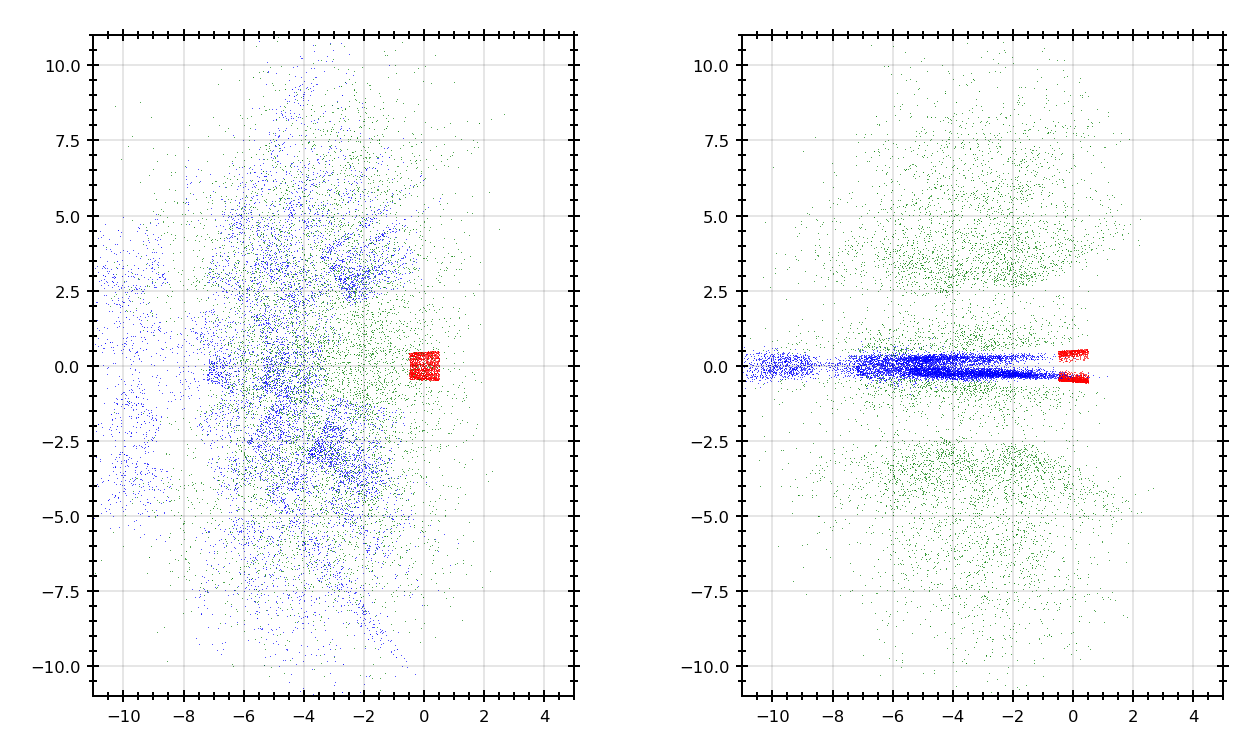

In [5]:
size, rat = 720, 1.75
fig_w, fig_h = size*rat, size
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, ts=1.25, minor=True, top_bool=True, tick_direction='inout',
                                   wspace=0.1)

lim = 11
colors = ['red', 'blue', 'green']
for i, region in enumerate(regions):
    galcen_table = data_dic[region]['data']
    ax = axs[0][0]
    ss = 0.01
    ax.scatter(galcen_table['x'], galcen_table['y'], 
            c=colors[i],
            s=ss*fs, linewidths=0)

    ax.set_xlim(-lim, lim//2)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')

    ax2 = axs[0][1]
    ax2.scatter(galcen_table['x'], galcen_table['z'], 
                c=colors[i],
                s=ss*fs, linewidths=0)

    ax2.set_xlim(-lim, lim//2)
    ax2.set_ylim(-lim, lim)
    ax2.set_aspect('equal')
    #ax.grid(which="major", linewidth=fs * 0.01, color="white",)
